In [1]:
from read_json import *
from spectrum_integrate import *
from plots import *
from source_filter import *
from variability_estimator import *

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table

In [3]:
## import

path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'
table_agn_pop_4lac_dr3 = Table.read(path_4lac_dr3_catalog, format='ascii.ecsv')
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

df_agn_pop_4lac_dr3.head()

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000
0,J0001.2+4741,0.3126,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,0.012156,bcu,ISP,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11
1,J0001.2-0747,0.3151,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,0.051182,bll,LSP,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11
2,J0001.4-0010,0.3717,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,0.132438,bll,LSP,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11
3,J0001.5+2113,0.3815,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,0.159319,fsrq,ISP,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11
4,J0001.6-4156,0.4165,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,0.072754,bcu,HSP,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11


In [4]:
## saving our changes in a separate dataframe

df_4lac_luana_dr3 = df_agn_pop_4lac_dr3.copy()

In [5]:
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(df_4lac_luana_dr3.columns[5:11], axis=1)
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(columns=['RAJ2000', 'DEJ2000', 'Redshift', 'Flux1000', 'Unc_Flux1000'])

In [6]:
## adding spectrum flux calculations

spectrum_flux_values = []
spectrum_flux_Flux1000comparison = []

for index, row in df_4lac_luana_dr3.iterrows():
    source_name = row['Source_Name']
    
    ## integrate from 1-100 GeV
    spectrum_flux_test, diff_flux_test, spec_type_test = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 1, 100)
    spectrum_flux_Flux1000comparison.append(spectrum_flux_test)
    
    ## integrate from 0.1-100 GeV
    spectrum_flux, diff_flux, spec_type = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 0.1, 100)
    spectrum_flux_values.append(spectrum_flux)

df_4lac_luana_dr3['Spectrum_Flux_Estimated'] = spectrum_flux_values

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/spectrum_integrate.py:71: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))),


In [7]:
## getting a list of the downloaded sources

folder_path = '../4LAC_lightcurve_downloader_v3/resulting_catalogs/input_lightcurve_downloads_v3/fixed_indexed_lightcurves/3days_ts1_fixedindex_lightcurves'

## glob to get all .json files in the folder
json_files = glob.glob(os.path.join(folder_path, '*.json'))
json_file_names = [os.path.basename(file)[5:17] for file in json_files]

len(json_file_names)

1429

In [8]:
## creating a df for the downloaded sources

df_filtered_4lac_luana_dr3 = df_4lac_luana_dr3[df_4lac_luana_dr3['Source_Name'].isin(json_file_names)].copy()
df_filtered_4lac_luana_dr3.reset_index(drop=True, inplace=True)

print(len(df_filtered_4lac_luana_dr3))

1429


In [9]:
json_source_names = df_filtered_4lac_luana_dr3['Source_Name'].tolist()

len(json_source_names)

1429

In [10]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit
## Input flux_error with previous bin 'flux'

## 3-days

source_names_3days = []
UL_bright_ratio_3days = []

## case zero
nExcess_3days_zero = []
unc_nExcess_3days_zero = []
fvar_3days_zero = []
unc_fvar_3days_zero = []

## case average
nExcess_3days_aver = []
unc_nExcess_3days_aver = []
fvar_3days_aver = []
unc_fvar_3days_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, '3-days', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, n_unconstrained = filter_outliers(source_df)
    
    ## UL check
    bright_ratio = n_unconstrained / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_3days.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_3days.append(source_name)
        
        nExcess_3days_zero.append(sigma_nxs)
        unc_nExcess_3days_zero.append(err_sigma_nxs)
        fvar_3days_zero.append(fvar)
        unc_fvar_3days_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_3days_aver.append(sigma_nxs_2)
        unc_nExcess_3days_aver.append(err_sigma_nxs_2)
        fvar_3days_aver.append(fvar_2)
        unc_fvar_3days_aver.append(err_fvar_2)
    
df_variability_3days_zero = pd.DataFrame(list(zip(source_names_3days, UL_bright_ratio_3days,
                                                     nExcess_3days_zero, unc_nExcess_3days_zero,
                                                     fvar_3days_zero, unc_fvar_3days_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(3_days)', 'Unc_Norm_Excess_Var(3_days)',
                                                      'Frac_Variability(3_days)', 'Unc_Frac_Variability(3_days)'])

df_variability_3days_aver = pd.DataFrame(list(zip(source_names_3days, UL_bright_ratio_3days,
                                                     nExcess_3days_aver, unc_nExcess_3days_aver,
                                                     fvar_3days_aver, unc_fvar_3days_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(3_days)', 'Unc_Norm_Excess_Var(3_days)',
                                                      'Frac_Variability(3_days)', 'Unc_Frac_Variability(3_days)'])

In [11]:
df_variability_3days_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
0,J0050.7-0929,0.853202,-1.033326,0.079326,0.000000,0.100000
1,J0102.8+5824,0.830059,0.279574,0.054481,0.528747,0.051519
2,J0108.6+0134,0.166150,1.561727,0.021272,1.249691,0.008511
3,J0112.1+2245,0.251847,0.388735,0.023720,0.623487,0.019022
4,J0120.4-2701,0.781161,-1.266344,0.082922,0.000000,0.100000
...,...,...,...,...,...,...
110,J2236.5-1433,0.733826,2.325538,0.078225,1.524971,0.025648
111,J2243.9+2021,0.744403,-0.747378,0.070669,0.000000,0.100000
112,J2253.9+1609,0.068000,4.208276,0.015420,2.051408,0.003758
113,J2329.3-4955,0.796154,2.648098,0.042912,1.627298,0.013185


In [12]:
df_variability_3days_aver

,Source_Name,Bright_Ratio,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
0,J0050.7-0929,0.853202,-0.549442,0.023098,0.000000,0.100000
1,J0102.8+5824,0.830059,-0.164500,0.013761,0.000000,0.100000
2,J0108.6+0134,0.166150,1.026166,0.014822,1.012998,0.007316
3,J0112.1+2245,0.251847,0.087264,0.011564,0.295405,0.019573
4,J0120.4-2701,0.781161,-0.645516,0.026138,0.000000,0.100000
...,...,...,...,...,...,...
110,J2236.5-1433,0.733826,0.529354,0.022396,0.727567,0.015391
111,J2243.9+2021,0.744403,-0.490374,0.023224,0.000000,0.100000
112,J2253.9+1609,0.068000,3.629802,0.013410,1.905204,0.003519
113,J2329.3-4955,0.796154,0.573906,0.011253,0.757566,0.007427


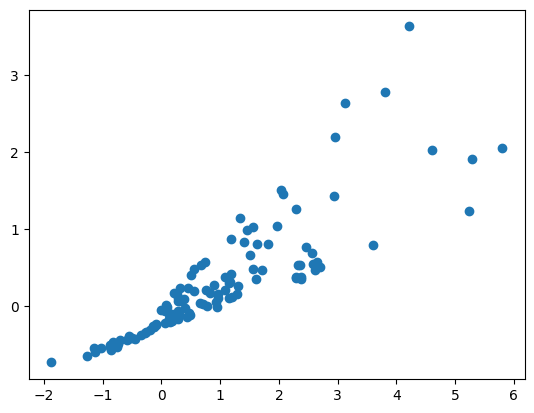

In [13]:
plt.scatter(df_variability_3days_zero['Norm_Excess_Var(3_days)'], df_variability_3days_aver['Norm_Excess_Var(3_days)'])

In [14]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit
## Input flux_error with previous bin 'flux'

## monthly

source_names_monthly = []
UL_bright_ratio_monthly = []

## case zero
nExcess_monthly_zero = []
unc_nExcess_monthly_zero = []
fvar_monthly_zero = []
unc_fvar_monthly_zero = []

## case average
nExcess_monthly_aver = []
unc_nExcess_monthly_aver = []
fvar_monthly_aver = []
unc_fvar_monthly_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'monthly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, n_unconstrained = filter_outliers(source_df)
    
    ## UL check
    if len(filtered_df['flux'].dropna()) != 0:
        bright_ratio = n_unconstrained / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
    # if len(filtered_df['flux'].dropna()) != 0:
        # print(bright_ratio)
        UL_bright_ratio_monthly.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_monthly.append(source_name)
        
        nExcess_monthly_zero.append(sigma_nxs)
        unc_nExcess_monthly_zero.append(err_sigma_nxs)
        fvar_monthly_zero.append(fvar)
        unc_fvar_monthly_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_monthly_aver.append(sigma_nxs_2)
        unc_nExcess_monthly_aver.append(err_sigma_nxs_2)
        fvar_monthly_aver.append(fvar_2)
        unc_fvar_monthly_aver.append(err_fvar_2)
    
df_variability_monthly_zero = pd.DataFrame(list(zip(source_names_monthly, UL_bright_ratio_monthly,
                                                     nExcess_monthly_zero, unc_nExcess_monthly_zero,
                                                     fvar_monthly_zero, unc_fvar_monthly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(monthly)', 'Unc_Norm_Excess_Var(monthly)',
                                                      'Frac_Variability(monthly)', 'Unc_Frac_Variability(monthly)'])

df_variability_monthly_aver = pd.DataFrame(list(zip(source_names_monthly, UL_bright_ratio_monthly,
                                                     nExcess_monthly_aver, unc_nExcess_monthly_aver,
                                                     fvar_monthly_aver, unc_fvar_monthly_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(monthly)', 'Unc_Norm_Excess_Var(monthly)',
                                                      'Frac_Variability(monthly)', 'Unc_Frac_Variability(monthly)'])

In [15]:
df_variability_monthly_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,0.738318,-0.827648,0.204485,0.000000,0.100000
1,J0001.5+2113,0.553719,2.312904,0.130572,1.520823,0.042928
2,J0009.3+5030,0.099415,0.201056,0.032965,0.448393,0.036759
3,J0011.4+0057,0.918367,1.132124,0.226301,1.064013,0.106343
4,J0021.5-2552,0.747664,-0.721438,0.193482,0.000000,0.100000
...,...,...,...,...,...,...
612,J2334.8+1432,0.821918,-0.271343,0.204287,0.000000,0.100000
613,J2338.0-0230,0.715789,0.137278,0.152017,0.370510,0.205146
614,J2345.2-1555,0.268966,2.171191,0.045225,1.473496,0.015346
615,J2347.0+5141,0.068182,0.141772,0.028442,0.376526,0.037769


In [16]:
df_variability_monthly_aver

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,0.738318,-0.519552,0.067671,0.000000,0.100000
1,J0001.5+2113,0.553719,0.727503,0.047618,0.852938,0.027914
2,J0009.3+5030,0.099415,0.083650,0.022065,0.289223,0.038145
3,J0011.4+0057,0.918367,0.056750,0.042922,0.238222,0.090089
4,J0021.5-2552,0.747664,-0.482306,0.063347,0.000000,0.100000
...,...,...,...,...,...,...
612,J2334.8+1432,0.821918,-0.331232,0.061543,0.000000,0.100000
613,J2338.0-0230,0.715789,-0.198011,0.046730,0.000000,0.100000
614,J2345.2-1555,0.268966,1.180393,0.026297,1.086459,0.012102
615,J2347.0+5141,0.068182,0.064176,0.020804,0.253330,0.041062


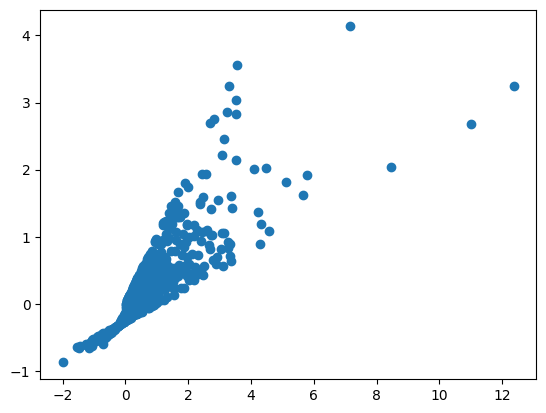

In [17]:
plt.scatter(df_variability_monthly_zero['Norm_Excess_Var(monthly)'], df_variability_monthly_aver['Norm_Excess_Var(monthly)'])

In [ ]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit
## Input flux_error with previous bin 'flux'

## weekly

source_names_weekly = []
UL_bright_ratio_weekly = []

## case zero
nExcess_weekly_zero = []
unc_nExcess_weekly_zero = []
fvar_weekly_zero = []
unc_fvar_weekly_zero = []

## case average
nExcess_weekly_aver = []
unc_nExcess_weekly_aver = []
fvar_weekly_aver = []
unc_fvar_weekly_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'weekly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, n_unconstrained = filter_outliers(source_df)
    
    ## UL check
    bright_ratio = n_unconstrained / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_weekly.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_weekly.append(source_name)
        
        nExcess_weekly_zero.append(sigma_nxs)
        unc_nExcess_weekly_zero.append(err_sigma_nxs)
        fvar_weekly_zero.append(fvar)
        unc_fvar_weekly_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_weekly_aver.append(sigma_nxs_2)
        unc_nExcess_weekly_aver.append(err_sigma_nxs_2)
        fvar_weekly_aver.append(fvar_2)
        unc_fvar_weekly_aver.append(err_fvar_2)
    
df_variability_weekly_zero = pd.DataFrame(list(zip(source_names_weekly, UL_bright_ratio_weekly,
                                                     nExcess_weekly_zero, unc_nExcess_weekly_zero,
                                                     fvar_weekly_zero, unc_fvar_weekly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(weekly)', 'Unc_Norm_Excess_Var(weekly)',
                                                      'Frac_Variability(weekly)', 'Unc_Frac_Variability(weekly)'])

df_variability_weekly_aver = pd.DataFrame(list(zip(source_names_weekly, UL_bright_ratio_weekly,
                                                     nExcess_weekly_aver, unc_nExcess_weekly_aver,
                                                     fvar_weekly_aver, unc_fvar_weekly_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(weekly)', 'Unc_Norm_Excess_Var(weekly)',
                                                      'Frac_Variability(weekly)', 'Unc_Frac_Variability(weekly)'])

In [ ]:
df_variability_weekly_zero

In [ ]:
df_variability_weekly_aver

In [ ]:
plt.scatter(df_variability_weekly_zero['Norm_Excess_Var(weekly)'], df_variability_weekly_aver['Norm_Excess_Var(weekly)'])

In [ ]:
## unifying in a single dataframe

In [ ]:
## merging our estimates

df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_monthly_zero, on='Source_Name', how='left')

In [ ]:
## merging our estimates

df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_monthly_zero, on='Source_Name', how='left')

In [ ]:
## a few plots

In [ ]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3-days Distribution')

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Weekly Distribution')

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()

plt.savefig('plots/excess_variance_distributions.png')

plt.show()


In [ ]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} points', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(plt.xlim())
plt.xlim(plt.ylim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days.png',dpi=300)
plt.show()

In [ ]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]
# x = x[x > 0]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? points', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days_log.png',dpi=300)
plt.show()

In [ ]:
## taking the log for the fit

x = df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)']
y = df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)']
x_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)']
y_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)']

In [ ]:
## filter out non-positive values
valid_indices = (x > 0) & (y > 0)

x = x[valid_indices]
y = y[valid_indices]
x_err = x_err[valid_indices]
y_err = y_err[valid_indices]

In [ ]:
len(x)

In [ ]:
## Log transformation
log_x = np.log(x)
log_y = np.log(y)
log_x_err = x_err / x  # relative error in log scale
log_y_err = y_err / y  # relative error in log scale

In [ ]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

# Set initial guess for the parameters [a, b]
initial_guess = [1.3, 1.0]

# Set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

# Run the ODR fitting
output = odr_instance.run()

# Extract the fitted parameters
a, b = output.beta
a = a+0.2
print(f"Fitted parameter: a = {a}")

# Plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='o', label='Data')
plt.plot(x_fit, y_fit, label=f'Fit: y = {a:.3f} * x', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


## Selection of sources which show significant variability on a monthly timescale

--> only select sources with $\sigma_{NXS}^{2}$(monthly) - 3*err$[\sigma_{NXS}^{2}]$(monthly) > 0

In [ ]:
table_4lac_luana_dr3 = Table.from_pandas(df_4lac_luana_dr3)
table_filtered_4lac_luana_dr3 = Table.from_pandas(df_filtered_4lac_luana_dr3) 

In [ ]:
## monthly significant 3 sigma

selected_indices = []

for index, row in enumerate(table_filtered_4lac_luana_dr3):
    
    ## Check if 'Norm_Excess_Var(monthly)' and 'Unc_Norm_Excess_Var(monthly)' are not None and not NaN
    if (row['Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Norm_Excess_Var(monthly)'])) and \
       (row['Unc_Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Unc_Norm_Excess_Var(monthly)'])):
        
        ## 3 sigma criteria
        if row['Norm_Excess_Var(monthly)'] - 3 * row['Unc_Norm_Excess_Var(monthly)'] > 0:
            selected_indices.append(index)  # add index to list

if selected_indices:
    table_selected_monthly = table_filtered_4lac_luana_dr3[selected_indices]
else:
    print("No rows satisfy the condition.")


In [ ]:
selected_table_monthly = table_selected_monthly.to_pandas()

In [ ]:
selected_table_monthly

In [ ]:
selected_table_monthly['Source_Name']

In [ ]:
source_names = selected_table_monthly['Source_Name']
source_names_file = 'source_names_384.txt'
source_names.to_csv(source_names_file, index=False, header=False)

In [ ]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(selected_table_monthly['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3-days Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Weekly Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()

plt.savefig('plots/selected_excess_variance_distributions.png')

plt.show()


In [ ]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]

plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
             xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} sources', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(plt.xlim())
plt.xlim(plt.ylim())

plt.grid(True)
plt.savefig('plots/selected_monthly_vs_3days.png',dpi=300)
plt.show()

In [ ]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]
# x = x[x > 0]

plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
             xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? sources', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

# plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.xlim(1e-2,1e1)

plt.grid(True)
plt.savefig('plots/selected_monthly_vs_3days_log.png',dpi=300)
plt.show()

In [ ]:
from scipy.optimize import curve_fit

## model y = a * x^b
def model(x, a, b):
    return a * x**b

data = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]
x = data['Norm_Excess_Var(monthly)']
y = data['Norm_Excess_Var(3_days)']
xerr = data['Unc_Norm_Excess_Var(monthly)']
yerr = data['Unc_Norm_Excess_Var(3_days)']

## fit with both a and b free
popt_free, pcov_free = curve_fit(model, x, y, sigma=yerr, absolute_sigma=True)
a_free, b_free = popt_free

## fit with b = 1 fixed
def model_fixed(x, a):
    return a * x

popt_fixed, pcov_fixed = curve_fit(model_fixed, x, y, sigma=yerr, absolute_sigma=True)
a_fixed = popt_fixed[0]

## create x-range for plotting the fits
x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
y_fit_free = model(x_fit, a_free, b_free)
y_fit_fixed = model_fixed(x_fit, a_fixed)

In [ ]:
## square roots of the diagonal elements of the covariance matrices
## (pcov_free and pcov_fixed)

## a & b free
a_free_err, b_free_err = np.sqrt(np.diag(pcov_free))
print(f"Fit with a and b free:")
print(f"  a = {a_free:.4e} ± {a_free_err:.4e}")
print(f"  b = {b_free:.4f} ± {b_free_err:.4f}")

## a free & b=1
a_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]
print(f"\nFit with b fixed (b=1):")
print(f"  a = {a_fixed:.4e} ± {a_fixed_err:.4e}")

In [ ]:
plt.figure(figsize=(8, 6), dpi=300)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.plot(x_fit, y_fit_free, label=f'Fit (free): $y = {a_free:.3f} * x^{{{b_free:.2f}}}$', color='red')
plt.plot(x_fit, y_fit_fixed, label=f'Fit (b=1): $y = {a_fixed:.3f} * x^1$', color='blue', linestyle='--')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} sources', fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, 1e1)
plt.grid(True)
plt.legend()
plt.savefig('plots/selected_monthly_vs_3days_log_fit.png', dpi=300)
plt.show()

In [ ]:
## bootstrap - 80% / 90% of points many times

previous fitting way

In [ ]:
## taking the log for the fit

x_previous = selected_table_monthly['Norm_Excess_Var(monthly)']
y_previous = selected_table_monthly['Norm_Excess_Var(3_days)']
x_err_previous = selected_table_monthly['Unc_Norm_Excess_Var(monthly)']
y_err_previous = selected_table_monthly['Unc_Norm_Excess_Var(3_days)']

In [ ]:
## filter out non-positive values
valid_indices = (x_previous > 0) & (y_previous > 0)

x_previous = x_previous[valid_indices]
y_previous = y_previous[valid_indices]
x_err_previous = x_err_previous[valid_indices]
y_err_previous = y_err_previous[valid_indices]

In [ ]:
len(x_previous)

In [ ]:
## Log transformation
log_x = np.log(x_previous)
log_y = np.log(y_previous)
log_x_err = x_err_previous / x_previous  # relative error in log scale
log_y_err = y_err_previous / y_previous  # relative error in log scale

In [ ]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

## et initial guess for [a, b]
initial_guess = [1.3, 1.0]

## set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

## run the ODR fitting
output = odr_instance.run()

## extract the fitted parameters
a, b = output.beta
a_err, b_err = output.sd_beta

print(f"Fitted parameter: a = {a} ± {a_err}")
print(f"Fitted parameter: b = {b} ± {b_err}")

## plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err,
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')
plt.plot(x_fit, y_fit, label=f'Fit: log(NXS_3days) = ({a:.3f} ± {a_err:.3f}) x log(NXS_monthly)', color='red')

plt.xlabel('log [$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$] (monthly)', fontsize=12)
plt.ylabel('log [$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$] (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x_data)} sources', fontsize=12)
plt.legend()

# plt.xlim(plt.ylim())
plt.ylim(-8,5)

plt.grid(True)
# plt.savefig('plots/selected_monthly_vs_3days_log_fit.png',dpi=300)
plt.show()


In [ ]:
## add column in our final selected table

# selected_table_monthly['Norm_Excess_Var_Extrapolated(3_days)'] = selected_table_monthly['Norm_Excess_Var(monthly)']**a

In [ ]:
table_selected_monthly = Table.from_pandas(selected_table_monthly)

In [ ]:
table_selected_monthly

In [ ]:
df_filtered_4lac_luana_dr3

In [ ]:
df_4lac_luana_dr3

In [ ]:
## save table

table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.fits', format='fits', overwrite=True)
table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.ecsv', format='ascii.ecsv', overwrite=True)

table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)

table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)